# Assignment Module 2 (2.7)
Data Steward 2024/25

Georg Schütz

## 

## Idea and Challenges: description

### Idea

Data extraction and manipulation of raw data from an Octet RED96e (BLI) instrument.
The device measures the binding rates of two different binding partners, whereby the concentration of one of the partners is varied.
So in general the output is a response (binding) versus time. 

Before the actual measurements, various blank and test measurements are taken, which are not really interesting. 

Unfortunately, there is no quick and easy way to extract the data of interest using the software supplied with the device. 

The program should quickly and automatically recognize the important area of the measurement and save both the plot and the data in a separate new xlsx file. 
 
<img src="./Explanation.png" width="640" height="360" float="right" >

### Challenges

#### 1) Detection of the Measuring Range
The raw data contains irrelevant areas that are mainly contained before the actual measurement (= calibration, blank measurements, etc.)
The correct range should be recognized --> User input is required here.

#### 2) Number of Samples & Duration of the Measurement
The device can measure up to 96 samples simultaneously. The number of samples and the number of measurement points therefore varies for each experiment. 
Furthermore, the measurement time is not constant and individual steps can be skipped manually. 
The script should function independently of varying sample numbers and measurement times. 









## The Design

<img src="./Assignment_design.png" width="360" height="640" float="right">


## Implementation

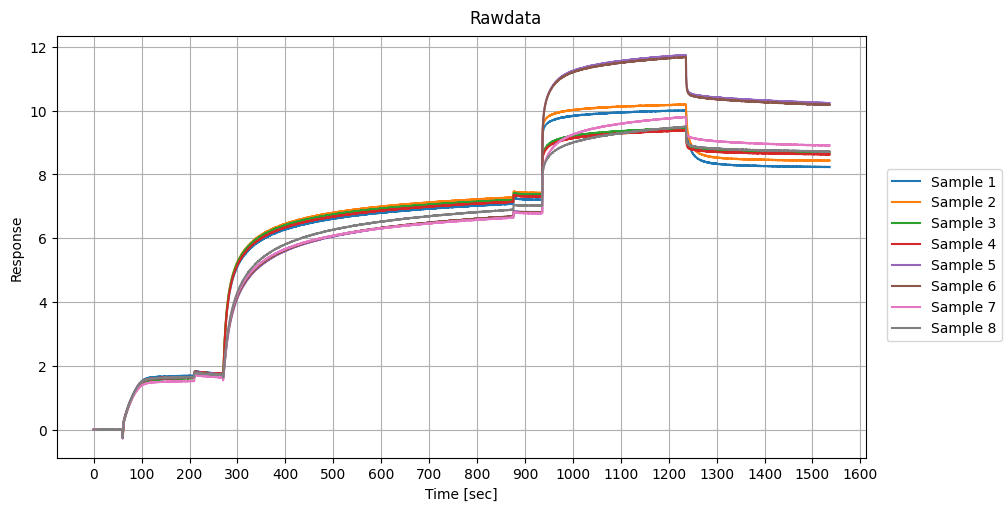

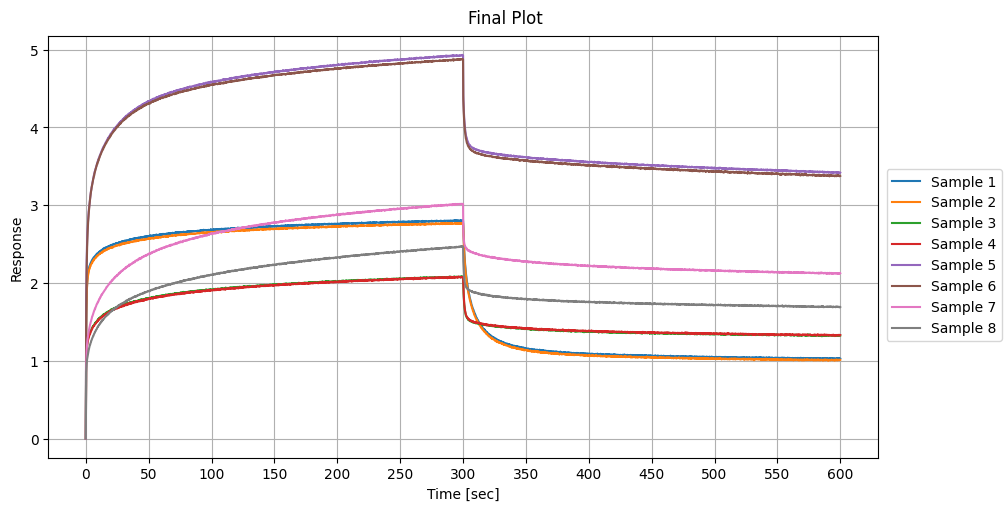

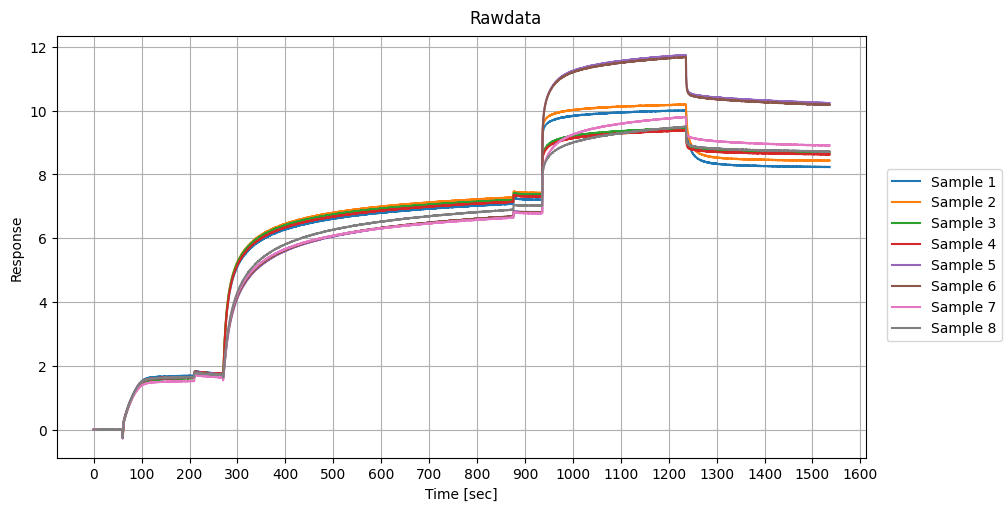

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.ticker import MultipleLocator
import tkinter as tk
from tkinter import ttk
import os
import xlwings as xw

# Change xls to xlsx
with xw.App(visible=False) as app:
    wb = app.books.open('RawData0.xls')
    wb.save('RawData0.xlsx')
    wb.close()
    
# Open xlsx file into df
df = pd.read_excel("RawData0.xlsx", header=0)

 
# Renaming of the columns
## Idea to make a def for column and rows
def col_name(dataframe, int):
    for i in range(0, dataframe.shape[1], 1):
        dataframe.columns.values[i] = i+int
    # for j in range(0, dataframe.shape[0], 1):
    #     dataframe.index.values[j] = j
        
# Def to delete colums or rows from a dataframe
def drop(old_df, start, stop, step, ax):
    drop_indices = list(range(start, stop, step))
    if step != 1: # letzte column ungerade muss auch weg - nur bei Step 2 wichtig
        drop_indices.append(old_df.shape[ax])
    new_df = old_df.drop(drop_indices, axis=ax)
    return new_df

# Renaming (start with col 1)     
col_name(df,1)

# Delete redundant time columns
df2 = drop(df, 3, df.shape[1], 2, 1)

# Renaming of columns. Start with 0 since "Time" should be 0
## Idea - Time not in a column but as the Index
col_name(df2,0)

#  Crat Plot of the Raw Data  
## define x and y values
x = df2[0] # Time in column 0
y = df2.iloc[:, 1:] # all rows, from column 1 to the end

# Figure settings
fig1 = plt.figure(figsize=(10,5), dpi=100, layout='compressed')
fig1.suptitle('Rawdata')

# Add Subpltot
ax = fig1.add_subplot(111)
ax.set_xlabel('Time [sec]')
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.set_ylabel('Response')

## Grid settings
ax.grid(which='both')

# Plot 
for column in y.columns:
    ax.plot(x, y[column], label = f'Sample {column}')

# Legend settings
fig1.legend(loc='outside right center')

def Show_RawData_plot():
    # Figure settings
    fig1 = plt.figure(figsize=(10,5), dpi=100, layout='compressed')
    fig1.suptitle('Rawdata')

    # Add Subpltot
    ax = fig1.add_subplot(111)
    ax.set_xlabel('Time [sec]')
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.set_ylabel('Response')

    ## Grid settings
    ax.grid(which='both')

    # Plot 
    for column in y.columns:
        ax.plot(x, y[column], label = f'Sample {column}')

    # Legend settings
    fig1.legend(loc='outside right center')
    
    # Figure des erstellten Plots kommt auch ins GUI
    RawData_plot = FigureCanvasTkAgg(fig1, master=root) # type: ignore
    RawData_plot.draw()
    RawData_plot.get_tk_widget(). grid(column=0, row=3, columnspan=6)

def calculate_plot():
    
    # Input in sec is not equal to index (5 points per second)
    # ## xstart as new variable (sec => Index)
    xstart = input_sec.get() * 5

    # # Check: when is the Experiment excactly starting
    # # start begins with a sharp increase in response 
    for i in range(xstart,df2.shape[0]-1):
        # for j in range(1,df2.shape[1]): # sollten die Columns auch durchgezählt werden müssen
        j = 1 # muss weg wenn die j Schleife arbeiten soll
        if df2.at[i+1,j]-df2.at[i,j] > 0.3:
            #print(i,j)
            #print(df2.at[i+1,j]-df2.at[i,j])
            t_value = i
            col_value = j
            break # mit Break hört die Schleife nach dem ersten Fund auf. Ohne Break würde der letzte Fund angezeigt werden

    # Delete all time points before the experiment start
    df3 = drop(df2, 0, t_value, 1, 0)

    # ReIndexing 
    df3.index = [list(range(1,df3.shape[0]+1,1))]

    # All columns are set to 0(Time)/0(Response) 
    ## New Data into New columns  
    for i in range(0,df3.shape[1],1):
        df3[i+df3.shape[1]] = df3[i]-df3.iat[0,i]

    # Old columns are deleted
    global df4
    df4 = drop(df3, 0, df2.shape[1], 1, 1)

    # Rename
    col_name(df4,0) 
    
    # Final Plot 
    ## Figure settings
    global fig2 
    fig2 = plt.figure(figsize=(10,5), dpi=100, layout='compressed')
    fig2.suptitle('Final Plot')

    ## Add subplot and setting
    ax = fig2.add_subplot(111)
    ax.set_xlabel('Time [sec]')
    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.set_ylabel('Response')
    ax.grid(which='both')

    ## X und Y Werte werden definiert
    x = df4[0]
    y = df4.iloc[:, 1:]

    ## Plot wird gemacht
    for column in y.columns:
        ax.plot(x, y[column], label=f'Sample {column}')

    ## Legend settings
    fig2.legend(loc='outside right center')
    
    # Figure des erstellten Plots kommt auch ins GUI
    FinalData = FigureCanvasTkAgg(fig2, master=root) # type: ignore
    FinalData.draw()
    FinalData.get_tk_widget(). grid(column=0, row=3, columnspan=6)


def save_files():
    try:
        os.mkdir("./NewFolder") # Create new directory
    except Exception as e:
        print(f"Folder already excist {e}")
     
    if agree_RawData.get() == True:
        with pd.ExcelWriter("./NewFolder/Output.xlsx") as writer:
            df2.to_excel(writer, sheet_name="Raw_Data", index=False)
            
    if agree_RawDataPlot.get() == True:     
        fig1.savefig("./NewFolder/Raw_Data_Plot.png")
        
    if agree_FinalData.get() == True:
        with pd.ExcelWriter("./NewFolder/Output.xlsx") as writer:  
            df4.to_excel(writer, sheet_name="Final_Data", index=False)
            
    if agree_FinalDataPlot.get() == True:   
        fig2.savefig("./NewFolder/Final_Data_Plot.png")
    else:
        print("Nix gespeichert")
    

# Creating a GUI for the first plot and Input Request 
root = tk.Tk()
root.title('Raw Data')
root.geometry()
root.resizable(False,False)

root.columnconfigure(0, weight=12)
root.columnconfigure(1, weight=6)
root.columnconfigure(2, weight=1)
root.columnconfigure(3, weight=1)
root.columnconfigure(4, weight=1)
root.columnconfigure(5, weight=1)

root.rowconfigure(0, weight=1)
root.rowconfigure(1, weight=1)
root.rowconfigure(2, weight=1)
root.rowconfigure(3, weight=1)

# Info Text field
Text1 = tk.Label(root, text="Enter time in [sec] just before your binding is going to start. \n Approximately ~25 sec before the start should be fine. \n \n With the test file 900 ist fine!")
Text1.grid(column=0, row=0, columnspan=2, sticky=tk.W, pady=20)

# Input field for the user - Sec ?
input_sec=tk.IntVar()
input=tk.Entry(root, textvariable=input_sec)
input.grid(column=1, row=0, sticky=tk.W, pady=20)

# Show RawData
RawData = tk.Button(root, text="Show Raw Data Plot", command = Show_RawData_plot)
RawData.grid(column=0, row=1, sticky=tk.NE, padx=20, pady=10)

# Calculate
calc = tk.Button(root, text="Calculate Final Plot", command=calculate_plot)
calc.grid(column=0, row=1, sticky=tk.NW, padx=20, pady=10)

# Save
save = tk.Button(root, text="Save in New Folder", command=save_files)
save.grid(column=1, row=1, sticky=tk.NE, pady=10, padx=10)

# Save Files Checkboxes
agree_RawData = tk.BooleanVar()
BOOL_RawData = ttk.Checkbutton(root, text="Raw Data", variable=agree_RawData, onvalue=True, offvalue=False )
BOOL_RawData.grid(column=2, row=1)

agree_RawDataPlot = tk.BooleanVar()
BOOL_RawDataPlot = ttk.Checkbutton(root, text="Raw Data Plot", variable=agree_RawDataPlot, onvalue=True, offvalue=False )
BOOL_RawDataPlot.grid(column=3, row=1)

agree_FinalData = tk.BooleanVar()
BOOL_FinalData = ttk.Checkbutton(root, text="Final Data", variable=agree_FinalData, onvalue=True, offvalue=False )
BOOL_FinalData.grid(column=4, row=1)

agree_FinalDataPlot = tk.BooleanVar()
BOOL_FinalDataPlot = ttk.Checkbutton(root, text="Final Data Plot", variable=agree_FinalDataPlot, onvalue=True, offvalue=False )
BOOL_FinalDataPlot.grid(column=5, row=1)

# Figure des erstellten Plots kommt auch ins GUI
RawData_plot = FigureCanvasTkAgg(fig1, master=root) # type: ignore
RawData_plot.draw()
RawData_plot.get_tk_widget(). grid(column=0, row=3, columnspan=6)

# Quit & Continue Button
Quit = tk.Button(root, text="Quit", command=root.destroy)
Quit.grid(column=0, row=4, columnspan=6, padx=20, pady=20)

# Start GUI
root.mainloop()

## Validation


I think testing was done all time with the intepreter.

--> everything happend...

--> Incorrect spelling, missing/wrong brackets, runtime error etc. etc. etc. 


Until now only 1 xlsx file as input file for the code was tested.

Since the script shall work with all different output files, I definietelly need to test the code with more than one xlsx file. 

## Thoughts 


I am highly motivated in learning python better. 
Almost everything was done using "google" searches and trying to get the solutions by reading and trying out. 
I would say parts of the code were re-written more than 5 times. 


Only twice I got help from chatgpd... but I was not asking to write the code but to correct the excisting code (both times because of logical-python mistakes from my side) ! 

 

## Future Goals

### For me
- learn python better...
- ask for feedback



### For the code
- reading original .xls file (with error message)   --> done
- Error Message and Work arround for the NewDirectory Error... (two times the same folder is not possible) --> done
- get a second GUI with the second final plot.--> done
  - or better try to get everything in one GUI and rewrite the GUI --> done
- ask the user where to save the Output xlsx file --> 
- Split the final data into two.. Binding Data and release data
- if duplicates or triplicates are made 
  - ask the user
  - average the du/triplicates
- fit the data
- make the code available without python? VSC?
  - as .exe ? in browser? no idea!!!